# EE4375: Sixth Lab Session: Galerkin Finite Element Method for the Poisson Equation on the Unit Square 

Solves the Poisson equation $- \bigtriangleup u = f$ on the unit square domain $\Omega=(0.,1.0)^2$ supplied with the homogeneous Dirichlet boundary condition $u = 0$ on $\Gamma$. The computational domain is kept simple on purpose for illustration purposes. The source function $f$ is defined as the sourcefct in what follows. Linear finite elements on triangular elements are used. The mesh is generated using the mesh generation software called gmsh (see [Gmsh](https://gmsh.info)).

## Import Packages

In [233]:
import gmsh 
using GR 

using LinearAlgebra 
using SparseArrays 
using StaticArrays
using StaticRanges
using StructArrays
using FastGaussQuadrature
using IterativeSolvers
using Preconditioners
using LinearSolve
using AlgebraicMultigrid: RugeStubenAMG, ruge_stuben,smoothed_aggregation, aspreconditioner

using BenchmarkTools
using Test 

using Plots 
using Profile
using ProfileView
using IncompleteLU


## Section 1: Struct and Auxilary Function Definitions 

In [181]:
# struct to hold 2D point
struct Point
  x::Float64   # x coordinates
  y::Float64   # y coordinates 
end

# struct to hold a single mesh element
struct Element
  p1::Point       # coordinates first node 
  p2::Point       # coordinates second node 
  p3::Point       # coordinates third node     
  e1::Int64       # global index first node
  e2::Int64       # global index second node
  e3::Int64       # global index third node
  area::Float64   # area of the element 
end

# struct to hold entire mesh
struct Mesh
  nnodes::Int64               # number of nodes 
  nelems::Int64               # number of elements
  Elements::Array{Element,1}  # list of Elements 
  bndNodeIds::Vector{Int64}   # indices of nodes where Dirichlet bc are applied  
  dofPerElem::Int64           # number of dofs per element 
end

In [182]:
# function area_triangle(p1::Point,p2::Point,p3::Point)
function area_triangle(p1,p2,p3)    
    x12 = p2.x - p1.x; x13 = p3.x-p1.x;
    y12 = p2.y - p1.y; y13 = p3.y-p1.y;
    area_id = x12*y13 - x13*y12; 
    area_id = abs(area_id)/2.
    return area_id 
end

area_triangle (generic function with 1 method)

## Section 2: Read Mesh From File and Define Mesh Structure  

In [183]:
# read elements from mesh file 
function meshFromGmsh(meshFile)    
    
    #..Initialize GMSH
    gmsh.initialize()
    
    #..Read mesh from file
    gmsh.open(meshFile)

    #..Get the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    #..Get the mesh elements
    #..Observe that we get all the two-dimensional triangular elements from the mesh
    element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
    nelems = length(element_ids[1])
      
    #..Construct uninitialized array of length nelements  
    Elements = Array{Element}(undef,nelems)

    #..Construct the array of elements 
    for element_id in 1:nelems
        e1 = element_connectivity[1][3*(element_id-1)+1]
        e2 = element_connectivity[1][3*(element_id-1)+2]
        e3 = element_connectivity[1][3*(element_id-1)+3]
        p1 = Point(sorted[e1,2], sorted[e1,3])
        p2 = Point(sorted[e2,2], sorted[e2,3])
        p3 = Point(sorted[e3,2], sorted[e3,3])
        area = area_triangle(p1,p2,p3); 
        Elements[element_id] = Element(p1,p2,p3,e1,e2,e3,area)
    end

    #..retrieve boundary nodes by loop over corner point and boundary edges
    node_ids1=[]; node_ids2=[]; node_ids3=[]; node_ids4=[]; 
    node_ids5=[]; node_ids6=[]; node_ids7=[]; node_ids8=[]; 
    node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
    node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
    node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
    node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
    node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,1)
    node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,2)
    node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,3)
    node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,4)
    bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
    
    #..Set DOF per element
    dofPerElement = 9 
    
    #..Store data inside mesh struct  
    mesh = Mesh(nnodes,nelems,Elements,bnd_node_ids,dofPerElement) 
    
    #..Finalize gmsh
    gmsh.finalize()
    
    return mesh 
end

#..read nodes from mesh file (useful for post-processing)
function nodesFromGmsh(meshFile)
    
    #..Initialize GMSH
    gmsh.initialize()
    
    #..Read mesh from file
    gmsh.open(meshFile)

    #..Get the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational
    #..efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    #..Finalize gmsh
    gmsh.finalize()
    
    return xnode,ynode 
end

nodesFromGmsh (generic function with 1 method)

## Section 3: FEM Assembly  

### Section 1.3: Stiffness Matrix Assembly  

In [184]:
function genLocStiffMat(element::Element)
    p1 = element.p1; p2 = element.p2; p3 = element.p3;  
    e1 = element.e1; e2 = element.e2; e3 = element.e3;  
    area = element.area 
    Iloc = SVector(e1, e1, e1, e2, e2, e2, e3, e3, e3)
    Jloc = SVector(e1, e2, e3, e1, e2, e3, e1, e2, e3)
    Xmat = SMatrix{3,3}(p1.x, p2.x, p3.x, p1.y, p2.y, p3.y, 1, 1, 1) 
    rhs  = SMatrix{3,3}(1., 0., 0., 0., 1., 0., 0., 0., 1.) 
    Emat = MMatrix{3,3}(Xmat\rhs);
    Emat[3,:] .= 0.;  
    Amat = SMatrix{3,3}(area*(transpose(Emat)*Emat));
    Aloc = [Amat[1,:] ; Amat[2,:] ; Amat[3,:] ] 
    return Iloc, Jloc, Aloc
end

function genStiffMat(mesh::Mesh)
 
    #..recover number of elements  
    nelems     = mesh.nelems 
    dofPerElem = mesh.dofPerElem;
     
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofPerElem*nelems)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues)) 

    for i = 1:nelems #..loop over number of elements..
        element          = mesh.Elements[i]
        Iloc, Jloc, Aloc = genLocStiffMat(element)
        irng             = mrange(dofPerElem*i-8, dofPerElem*i) 
        I[irng]          = Iloc 
        J[irng]          = Jloc 
        Avalues[irng]    = Aloc         
    end
    
    A = sparse(I,J,Avalues)
   
    return A; 
end

genStiffMat (generic function with 1 method)

### Section 2.3: Mass Matrix Assembly

In [185]:
function genLocMassMat(element::Element)
    p1 = element.p1; p2 = element.p2; p3 = element.p3;  
    e1 = element.e1; e2 = element.e2; e3 = element.e3;  
    area = element.area 
    Iloc = SVector(e1, e1, e1, e2, e2, e2, e3, e3, e3)
    Jloc = SVector(e1, e2, e3, e1, e2, e3, e1, e2, e3)
    Mloc = SMatrix{3,3}(area/3, 0., 0., 0., area/3, 0., 0., 0., area/3) 
    return Iloc, Jloc, Mloc
end

function genMassMat(mesh::Mesh)
 
    #..recover number of elements  
    nelems     = mesh.nelems 
    dofPerElem = mesh.dofPerElem;
     
    #..preallocate the memory for local matrix contributions 
    Mvalues = zeros(Float64,dofPerElem*nelems)
    I = zeros(Int64,length(Mvalues))
    J = zeros(Int64,length(Mvalues)) 

    for i = 1:nelems #..loop over number of elements..
        element          = mesh.Elements[i]
        Iloc, Jloc, Mloc = genLocMassMat(element)
        irng             = mrange(dofPerElem*i-8, dofPerElem*i) 
        I[irng]          = Iloc 
        J[irng]          = Jloc 
        Mvalues[irng]    = Mloc         
    end
    
    M = sparse(I,J,Mvalues)
   
    return M; 
end

genMassMat (generic function with 1 method)

### Section 3.3: Right-Hand Side Assembly using Analytically Specified Source Function 

In [186]:
mySourceFct(x,y) = x+y 

function genLocVector(element::Element, sourceFct::Function)
    p1 = element.p1; p2 = element.p2; p3 = element.p3;  
    e1 = element.e1; e2 = element.e2; e3 = element.e3;  
    area = element.area 
    Iloc = SVector(e1, e2, e3) 
    # use broadcast for the lines below instead 
    f1 = area/3*sourceFct(p1.x,p1.y)
    f2 = area/3*sourceFct(p2.x,p2.y)
    f3 = area/3*sourceFct(p3.x,p3.y)
    floc = SVector(f1, f2, f3) 
    return Iloc, floc
end

function genVector(mesh, sourceFct::F) where F 
 
    #..recover number of elements  
    nelems  = mesh.nelems 
    nnodes = mesh.nnodes 
     
    #..preallocate the memory for local matrix contributions 
    f = zeros(Float64,nnodes)

    for i = 1:nelems #..loop over number of elements..
        element::Element = mesh.Elements[i]
        Iloc, floc = genLocVector(element,sourceFct)
        f[Iloc] += floc 
    end
       
    return f; 
end

genVector (generic function with 1 method)

## Section 4: FEM Solve  

### Section 1.4: Handle Dirichlet Essential Boundary Conditions 

In [187]:
function handleBoundary!(mesh,A,f)
    bndNodeIds = mesh.bndNodeIds; 
    #..handle essential boundary conditions 
    A[bndNodeIds,:] .= 0;
    A[bndNodeIds,bndNodeIds] = Diagonal(ones(size(bndNodeIds)))
    f[bndNodeIds] .= 0;
    return A, f  
end

handleBoundary! (generic function with 1 method)

### Section 2.4: Solve Linear System 

In [188]:
function LU_pre(m)
    return lu(m)
end

function LU_calc(lu, f)
    return lu\f
end

function backslash(m::Tridiagonal{Float64, Vector{Float64}}, f::Vector{Float64})
    return m\f
end

backslash (generic function with 1 method)

In [189]:
function mesh_maker(n)
    elapsed_time_meshProduce = @elapsed begin
        #..1/4: initialize gmsh 
        gmsh.initialize()

        #..2/4: generate geometry 
        gmsh.option.setNumber("General.Terminal", 1)
        gmsh.model.add("square")
        #..set mesh density parameter 
        lc = 1/n
        #..define four points via (x,y,z) coordinates 
        gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
        gmsh.model.geo.addPoint(1., 0,  0, lc, 2)
        gmsh.model.geo.addPoint(1., 1., 0, lc, 3)
        gmsh.model.geo.addPoint(0, 1., 0, lc, 4)
        #..define four edges by connecting point labels pairwise  
        gmsh.model.geo.addLine(1, 2, 1)
        gmsh.model.geo.addLine(2, 3, 2)
        gmsh.model.geo.addLine(3, 4, 3)
        gmsh.model.geo.addLine(4, 1, 4)
        #..define curved loop by connecting four edge labels  
        gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
        #..define surface by curved loop 
        gmsh.model.geo.addPlaneSurface([1], 1)
        #..give label to the surface 
        #..syntax of the function being used is gmsh.model.setPhysicalName(dim, tag, name) 
        gmsh.model.setPhysicalName(2, 1, "My surface")
        #..synchronize model 
        gmsh.model.geo.synchronize()

        #..3/4: generate two-dimensional mesh 
        gmsh.model.mesh.generate(2)
        #..if true, write mesh to file for further processing 
        if (true) gmsh.write("square.msh") end 
        #..if true, visualize mesh through the GUI 
        if (false) gmsh.fltk.run() end 
    end 
    return elapsed_time_meshProduce  
end

mesh_maker (generic function with 1 method)

In [235]:
function solve_and_write_time(n)
    
    ret = zeros(8);

    ret[1] = mesh_maker(n) # retrieve the time of produceing the meshfile with dens=1/n

    mesh = meshFromGmsh("square.msh"); 
    
    elapsed_time_assembly =@elapsed begin
        A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); # <= force recompilation
        A,f = handleBoundary!(mesh,A,f); 
    end
    
    ret[2]= elapsed_time_assembly

    #Measure the time to solve the linear system with the cg method
    
    elapsed_time_solving = @elapsed begin
        preconditioner = ilu(A)
        x = cg(A, f, Pl=preconditioner)
    end

    ret[3] = elapsed_time_solving

    #Measure the time to solve the linear system with the AMG algorithm
    # smoothed_aggregation

    elpased_time_AMGsa= @elapsed begin
        ml_sa = smoothed_aggregation(A)
        p_sa = aspreconditioner(ml_sa)
        x = cg(A, f, Pl = p_sa)
    end

    ret[4]= elpased_time_AMGsa 

    # ruge_stuben

    elpased_time_AMGrs= @elapsed begin

        solve(A,f,RugeStubenAMG())
        #ml_rs = ruge_stuben(A)
        #p_rs = aspreconditioner(ml_rs)
        #x = cg(A, f, Pl = p_rs)
    end

    ret[5]= elpased_time_AMGrs 
    
    #=
    Measure the time to solve the linear system with the MINRES algorithm
    elapsed_time_minres = @elapsed begin
        abstol=1e-14
        x=minres(A,f,maxiter=200,abstol=abstol)
    end
    ret[6] = elapsed_time_minres
    =#

    #Measure the time to solve the linear system with the LU decomposition and \ operator
    #A=Tridiagonal(A)

    
    elapsed_time_LU = @elapsed begin
        luMat = LU_pre(A)     
        x = LU_calc(luMat, f)
    end
    
    ret[7]=elapsed_time_LU

    ret[8] = size(f)[1]

    return ret
end


solve_and_write_time (generic function with 1 method)

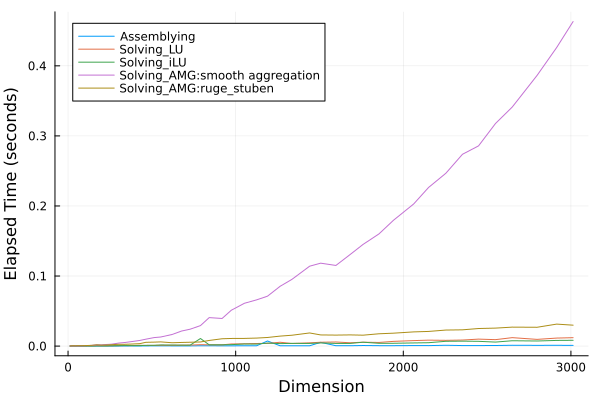

In [236]:

# Set the dimensions for the loop (e.g., from 2 to 100000 with a step of 1000)
dimensions = 2:1:50

times_assembly = []
times_iLU = []
times_LU = []
times_minres=[]
times_AMGsa=[]
times_AMGrs=[]
times_meshProduce=[]
steps = []

#times_minres = []
# Solve linear systems and collect elapsed times
for n in dimensions
    time = solve_and_write_time(n)

    push!(steps, time[8])
    
    push!(times_meshProduce,time[1])
    push!(times_assembly, time[2])
    

    push!(times_iLU, time[3])
    push!(times_minres,time[6])

    push!(times_LU,time[7])
    
    push!(times_AMGsa,time[4])
    push!(times_AMGrs,time[5])
    
end

# Plot the graph
Plots.plot(steps, times_assembly, xlabel="Dimension", ylabel="Elapsed Time (seconds)", label="Assemblying", legend=:topleft)
#Plots.plot!(steps, times_meshProduce, label="meshProduce")
Plots.plot!(steps,times_LU, label="Solving_LU")
Plots.plot!(steps,times_iLU, label="Solving_iLU")
#plots.plot!(dimensions,times_minres, label="Solving MINRES")
Plots.plot!(steps,times_AMGsa, label="Solving_AMG:smooth aggregation")
Plots.plot!(steps,times_AMGrs, label="Solving_AMG:ruge_stuben")

In [81]:
function generateSolution(mesh,A,f)

    A, f = handleBoundary!(mesh,A,f)
    u = A\f 
    return u 
end

generateSolution (generic function with 1 method)

In [82]:
mesh = meshFromGmsh("square-1.msh");   
A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); # <= force recompilation
@time generateSolution(mesh,A,f);

Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'
  0.005270 seconds (2.44 k allocations: 169.534 KiB, 99.05% compilation time)


Info    : Reading 'square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'square-10.msh'
  0.000019 seconds (10 allocations: 1.109 KiB)


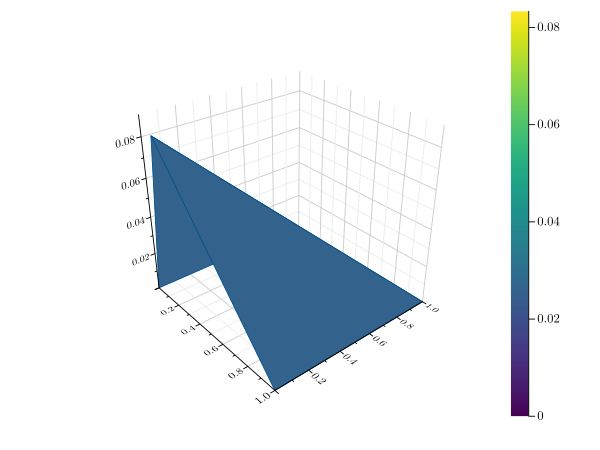

In [83]:
xnode,ynode = nodesFromGmsh("square-10.msh")
@time u = generateSolution(mesh,A,f)
GR.trisurf(xnode,ynode,u)

## Section 3: Magnetic Field by Coil  

In [84]:
# source function attached to the callable struct 
function mySourceFct(x,y)
    return (x>0.3)*(x<0.7)*(y>0.7)*(y<0.9) - (x>0.3)*(x<0.7)*(y>0.1)*(y<0.3)
#    return (x.>0.3)
end

mySourceFct (generic function with 1 method)

In [85]:
mesh = meshFromGmsh("square-100.msh"); 
A = genStiffMat(mesh); f= generateVector(mesh,mySourceFct); 
u = generateSolution(mesh,A,f);

GR.subplot(1,2,1)
p1 = GR.trisurf(xnode,ynode,f)
GR.subplot(1,2,2)
p1 = GR.tricont(xnode,ynode,u)

BoundsError: BoundsError: attempt to access 0-element Vector{Vector{UInt64}} at index [1]

In [86]:
mesh = meshFromGmsh("square-100.msh"); 
xnode,ynode = nodesFromGmsh("square-100.msh")
A = genStiffMat(mesh); f= generateVector(mesh,mySourceFct); 
u = generateSolution(mesh,A,f);

GR.subplot(1,2,1)
p1 = GR.trisurf(xnode,ynode,f)
GR.subplot(1,2,2)
p1 = GR.tricont(xnode,ynode,u)

BoundsError: BoundsError: attempt to access 0-element Vector{Vector{UInt64}} at index [1]

## Section 4: Post-Processing for the Magnetic Flux 

In [87]:
function genDerivLoc(element::Element,u)
    p1 = element.p1; p2 = element.p2; p3 = element.p3;  
    e1 = element.e1; e2 = element.e2; e3 = element.e3;  
    area = element.area 
    uloc1 = u[e1]; uloc2 = u[e2]; uloc3 = u[e3]; 
    Xmat = SMatrix{3,3}(p1.x, p2.x, p3.x, p1.y, p2.y, p3.y, 1, 1, 1) 
    rhs  = SMatrix{3,3}(1., 0., 0., 0., 1., 0., 0., 0., 1.) 
    Emat = MMatrix{3,3}(Xmat\rhs);
    Emat[3,:] .= 0.; 
    xmid = (p1.x+p2.x+p3.x)/3
    ymid = (p1.y+p2.y+p3.y)/3
    Bx = uloc1*Emat[2,1]+uloc2*Emat[2,2]+uloc3*Emat[2,3]
    By = uloc1*Emat[1,1]+uloc2*Emat[1,2]+uloc3*Emat[1,3]
    normB2 = Bx^2 + By^2 
    return xmid, ymid, Bx, By, normB2
end

function genDeriv(mesh, u)

    #..recover number of elements  
    nelems  = mesh.nelems 
    nnodes = mesh.nnodes 

    #..allocate memory for arrays 
    xmid = zeros(nelems,1)
    ymid = zeros(nelems,1)
    Bx = zeros(nelems,1)
    By = zeros(nelems,1)
    normB2 = zeros(nelems,1)

    for element_id in 1:nelems
        element::Element = mesh.Elements[element_id]
        xmid[element_id], ymid[element_id], Bx[element_id], By[element_id], normB2[element_id] = genDerivLoc(element,u) 
    end 
    
    return xmid, ymid, Bx, By, normB2 
end

genDeriv (generic function with 1 method)

In [88]:
#GR.tricont

GKS: Viewport is not within the NDC unit square in routine SET_VIEWPORT


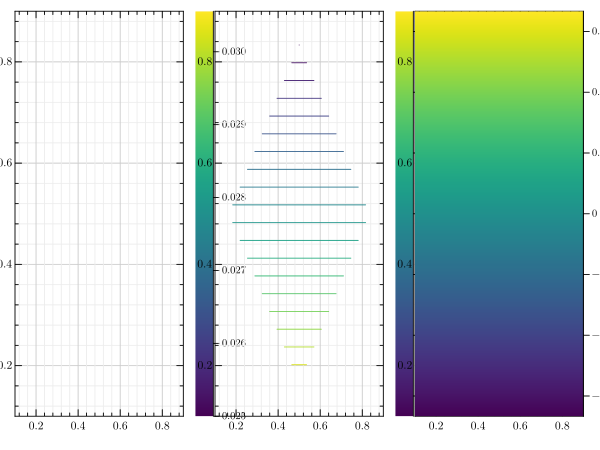

In [89]:
xmid, ymid, Bx, By, normB2 = genDeriv(mesh, u)
GR.subplot(1,3,1)
p1 = GR.tricont(xmid,ymid,normB2)
GR.subplot(1,3,2)
p1 = GR.tricont(xmid,ymid,Bx)
GR.subplot(1,3,3)
p1 = GR.tricont(xmid,ymid,By)